In [169]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import LapSRN
import ImageDataset
import YuvImageDataset
import test_utils
from skimage import io, transform
from skimage.color import rgb2yuv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import importlib
%matplotlib inline

In [303]:
importlib.reload(LapSRN);
importlib.reload(test_utils);
importlib.reload(YuvImageDataset);

In [238]:
input_size=64
upsample_levels=2
scale = 4
dataset = YuvImageDataset.YuvImageDataset(['../data/Set5/image_SRF_2', 'data/BSDS300/images/train'],
                        lowest_size=input_size, upsample_levels=upsample_levels)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
test_dataset = YuvImageDataset.YuvImageDataset(['../data/BSDS300/images/test'], lowest_size=input_size,
                                                upsample_levels=upsample_levels)

In [295]:
# import weights from matlab pretrained model
import scipy.io
mat_weights = scipy.io.loadmat('pretrained/LapSRN_x4.mat')['net'][0][0][1][0]
mat = dict()
for i in range(len(mat_weights)):
    mat[mat_weights[i][0][0]] = mat_weights[i][1]
    #print(mat_weights[i][0][0], mat_weights[i][1].shape)
lap_srn_pretrained = LapSRN.LapSRN(scale=scale, input_channels=1).cuda()  
lap_srn_pretrained.init_from_mat(mat)
lap_srn_pretrained = lap_srn_pretrained.cuda()

In [193]:
lap_srn = LapSRN.LapSRN(scale=scale, input_channels=1).cuda()
lap_srn.load_state_dict(torch.load('model/yuv_retrain_32x32'))

In [ ]:
criterion = LapSRN.L1_Charbonnier_loss() #nn.L1Loss()
optimizer = optim.Adam(lap_srn.parameters(), lr=1e-4)
losses = []
min_loss = 100000
min_val_psnr = 100000
for epoch in range(8001):
    for i, data in enumerate(data_loader):
        input_img = Variable(data['yuv_input_img'][:, 0, :, :].unsqueeze(1).cuda())
        optimizer.zero_grad()   # zero the gradient buffers
        outputs = lap_srn(input_img)
        losses = []
        for level in range(len(outputs)):
            #print(outputs)
            losses.append(criterion(outputs[level],
                                    Variable(data['y_hr_reference_'+str(level+1)].cuda(), requires_grad=False)))
        total_loss = sum(losses)
        total_loss.backward()
        optimizer.step()    # Does the update
#     valset_metrics = eval_on_valset(test_dataset, lap_srn, cuda = True)
#     if total_loss.data[0] < min_loss:
#         torch.save(lap_srn.state_dict(), 'model/yuv_retrain_32x32')
#     if valset_metrics < min_val_psnr:
#         torch.save(lap_srn.state_dict(), 'model/best_inpaint_val_weights_32x32_tune')
    if epoch%50 == 0:
        print('train_loss: {0:.4f}'.format(total_loss.data[0]))

train_loss: 63213.6328


In [214]:
# Model taken from https://github.com/twtygqyy/pytorch-LapSRN repository.
model = torch.load("model_epoch_100.pth")["model"]
model = model.cuda()

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LeakyReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [293]:
psnrs=test_utils.calculate_PSNR([lap_srn, model], test_dataset, scale=4, n_samples=np.inf)
print("My LapSRN PSNR:\t\t"+str(psnrs[0]))
print("Pretrained LapSRN PSNR:\t"+str(psnrs[1]))

My LapSRN PSNR:		27.3058939157
Pretrained LapSRN PSNR:	26.8829047181


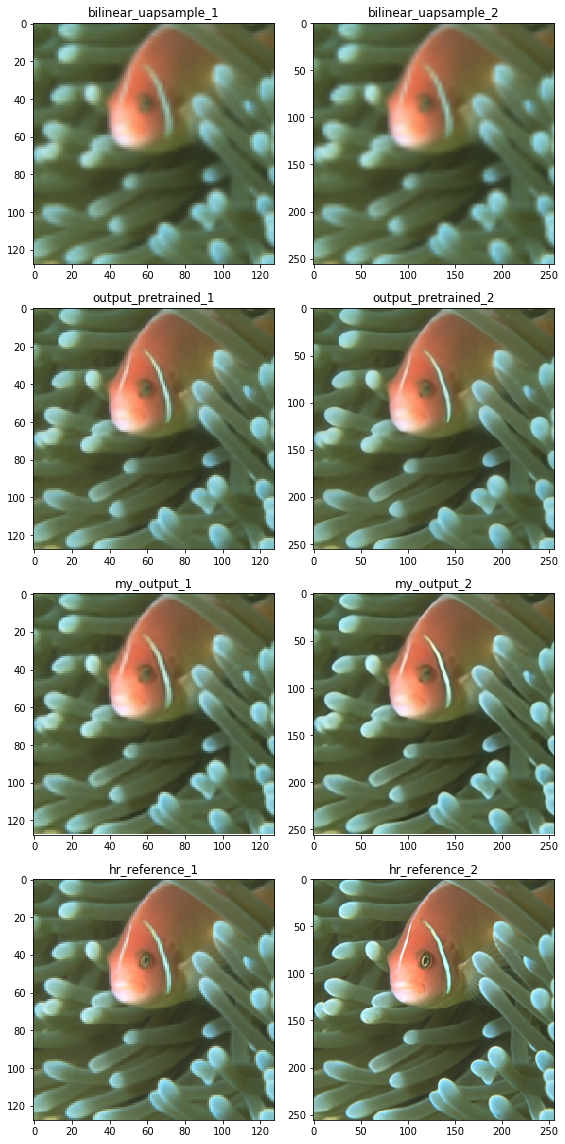

In [304]:
# Comparison of my LapSRN with https://github.com/twtygqyy/pytorch-LapSRN repository model.
test_utils.compare_results(lap_srn, test_dataset.__getitem__(13), pretrained_lapsrn=model);

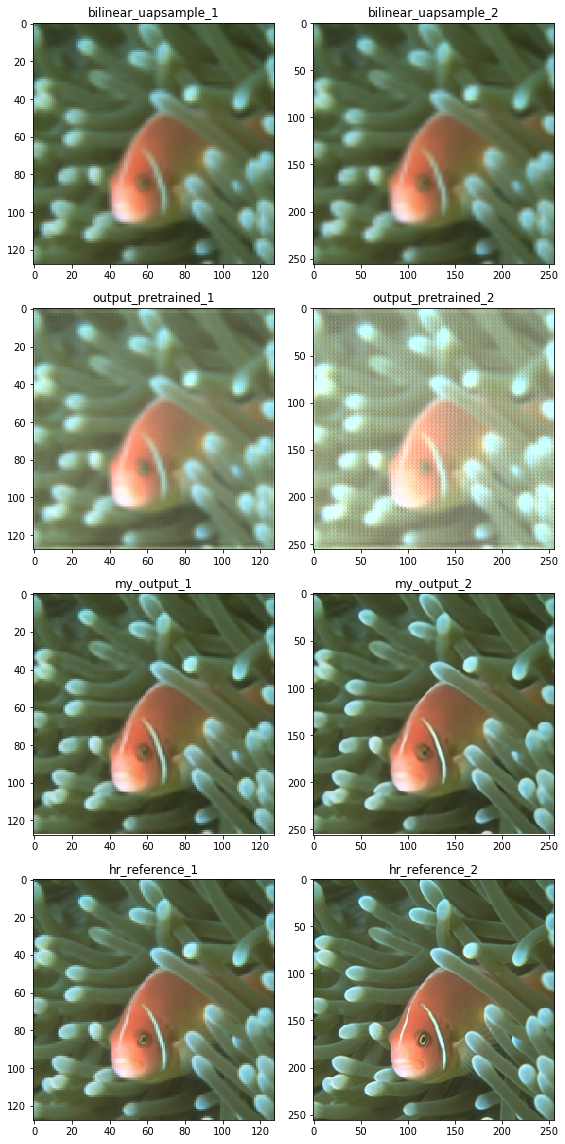

In [305]:
# Comparison of my LapSRN with LapSRN model with weights loaded from mat.
test_utils.compare_results(lap_srn, test_dataset.__getitem__(13), pretrained_lapsrn=lap_srn_pretrained);

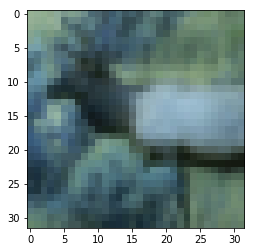

In [58]:
sample = test_dataset.__getitem__(12)
yuv_img = transforms.ToPILImage()(sample['yuv_input_img'])
plt.imshow(ycbcr2rgb(np.array(yuv_img)))

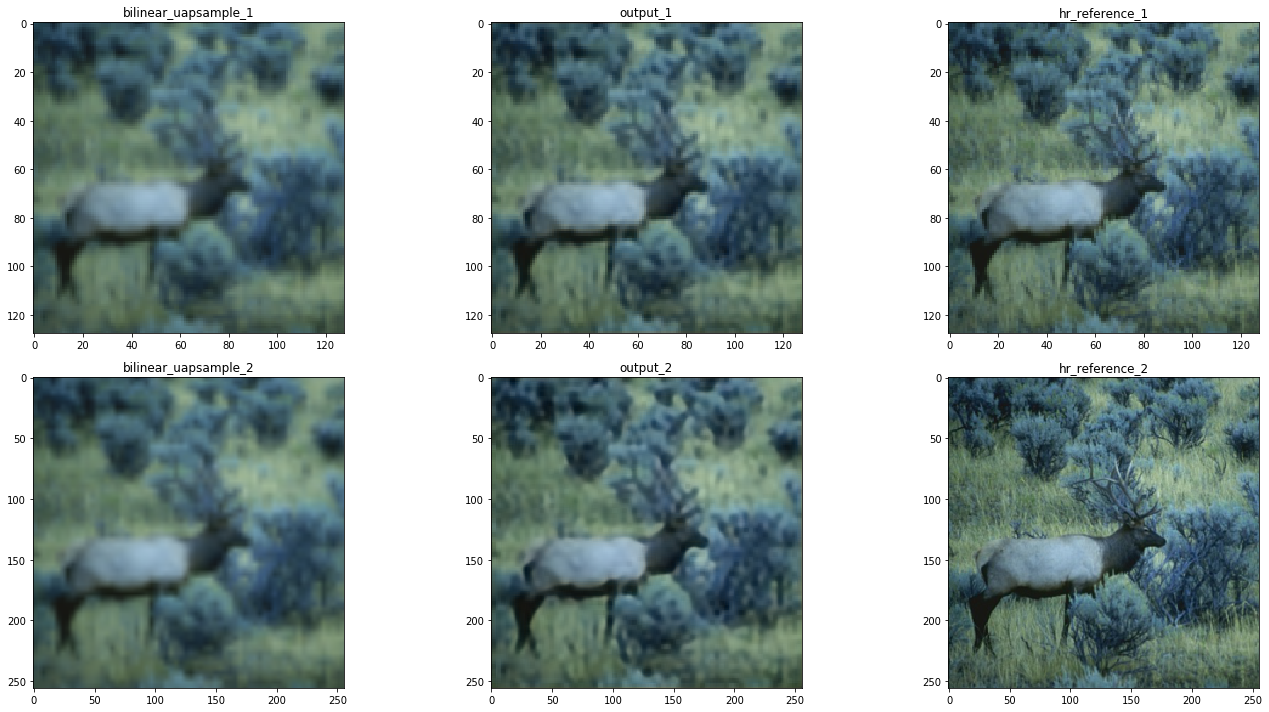

In [36]:
compare_results(lap_srn, sample);

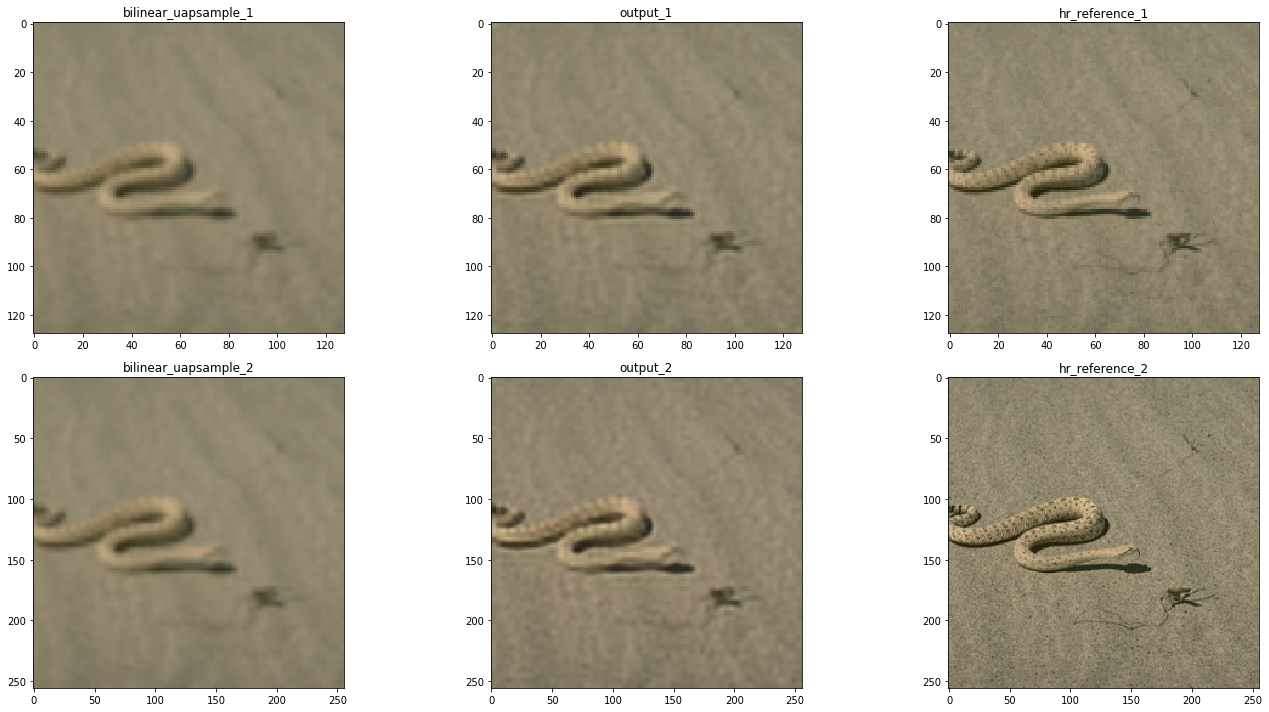

In [20]:
compare_results(lap_srn, sample);